In [1]:
from pathlib import Path
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Bidirectional, Reshape, TimeDistributed
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from matplotlib import pyplot
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from tensorflow.keras import backend as K
from tensorflow.keras.losses import BinaryCrossentropy
from pymms.sdc import mrmms_sdc_api as mms
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
import datetime as dt
import os
import time
import sklearn
import scipy
import pickle
import random
import requests
import sys
from imblearn.under_sampling import RandomUnderSampler

tf.compat.v1.disable_v2_behavior()



Instructions for updating:
non-resource variables are not supported in the long term


In [9]:
#### set filepath and import data csv
fpath = 'C:/Users/Davis/Desktop/'
fname = 'SWNewData' + '.csv'
file = fpath+fname
mms_data = pd.read_csv(file, index_col=0, infer_datetime_format=True, parse_dates=[0])

In [10]:
index = mms_data.index
selections = mms_data.pop("selected")
column_names = mms_data.columns

mms_data = mms_data.replace([np.inf, -np.inf], np.nan)
mms_data = mms_data.interpolate(method='time', limit_area='inside')

scaler = preprocessing.StandardScaler()
mms_data = scaler.fit_transform(mms_data)
mms_data = pd.DataFrame(mms_data, index, column_names)
mms_data = mms_data.join(selections)

In [12]:
sitl_windows = mms.mission_events('sroi', mms_data.index[0].to_pydatetime(), mms_data.index[-1].to_pydatetime(), sc='mms1')
windows = []
for start, end in zip(sitl_windows['tstart'], sitl_windows['tend']):
  window = mms_data[start:end]
  if not window.empty and len(window[window['selected']==True])>1:
    windows.append(window)
    


In [13]:
false_weight = len(mms_data)/(2*np.bincount(mms_data['selected'].values)[0])
true_weight = len(mms_data)/(48*np.bincount(mms_data['selected'].values)[1])
print(false_weight, true_weight)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
#x_under = np.squeeze(x_under)
#x_under = np.expand_dims(x_under, axis=2)
print(x_under.shape, y_under.shape)

In [6]:
SEQ_LEN = 350
while True:
    X_train, X_test, y_train, y_test = [], [], [], []

    sequences = []
    for i in range(len(windows)):
      X_sequence = []
      y_sequence = []

      if random.random() < 0.7:
        for value in windows[i].values:
          X_sequence.append(value[:-1])
          y_sequence.append(value[-1])
          if len(X_sequence) == SEQ_LEN:
            X_train.append(X_sequence.copy())
            
            y_train.append(y_sequence.copy())

            X_sequence = []
            y_sequence = []

      else:
        for value in windows[i].values:
          X_sequence.append(value[:-1])
          y_sequence.append(value[-1])
          if len(X_sequence) == SEQ_LEN:
            X_test.append(X_sequence.copy())
            
            y_test.append(y_sequence.copy())

            X_sequence = []
            y_sequence = []

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.expand_dims(np.array(y_train), axis=2)
    y_test = np.expand_dims(np.array(y_test), axis=2)

    if len(X_train) > len(X_test):
        break

In [7]:
#y_train = np.expand_dims(y_train, axis=2)
#y_test = np.expand_dims(y_test, axis=2)
print(y_train.shape, y_test.shape)

(2391, 350, 1) (964, 350, 1)


In [8]:
print(f"Number of sequences in training data: {len(X_train)}")
print(f"Number of sequences in test data: {len(X_test)}")
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

Number of sequences in training data: 2391
Number of sequences in test data: 964
(2391, 350, 129) (964, 350, 129)
(2391, 350, 1) (964, 350, 1)


In [23]:
# (Credit: Paddy and Kev1n91 from https://stackoverflow.com/a/45305384/3988976)
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [15]:
# (Credit: tobigue from https://stackoverflow.com/questions/42158866/neural-network-for-multi-label-classification-with-large-number-of-classes-outpu)
def weighted_binary_crossentropy(target, output):
    """
    Weighted binary crossentropy between an output tensor 
    and a target tensor. POS_WEIGHT is used as a multiplier 
    for the positive targets.

    Combination of the following functions:
    * keras.losses.binary_crossentropy
    * keras.backend.tensorflow_backend.binary_crossentropy
    * tf.nn.weighted_cross_entropy_with_logits
    """
     # transform back to logits
    _epsilon = tf.convert_to_tensor(K.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    output = tf.math.log(output / (1 - output))
    # compute weighted loss
    #target = tf.cast(target)
    loss = tf.nn.weighted_cross_entropy_with_logits(labels=target,
                                                    logits=output,
                                                    pos_weight=true_weight)
    return tf.reduce_mean(loss, axis=-1)

In [11]:
EPOCHS = 150
BATCH_SIZE = 80
LAYER_SIZE = 375


In [12]:
model_name = f"{SEQ_LEN}-SEQ_LEN-{BATCH_SIZE}-BATCH_SIZE-{LAYER_SIZE}-LAYER_SIZE-{int(time.time())}"

model = Sequential()

model.add(Bidirectional(LSTM(LAYER_SIZE, return_sequences=True), input_shape= (None, X_train.shape[2])))

model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(LAYER_SIZE, return_sequences=True), input_shape= (None, X_train.shape[2])))

model.add(TimeDistributed(Dense(1, activation='sigmoid')))

opt = tf.keras.optimizers.SGD()



model.summary()

    


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, None, 750)         1515000   
_________________________________________________________________
dropout (Dropout)            (None, None, 750)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 750)         3378000   
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1)           751       
Total params: 4,893,751
Trainabl

In [13]:
model.compile(loss = weighted_binary_crossentropy,
        optimizer=opt,
        metrics=['accuracy', f1, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


In [14]:
filepath = "C:/Users/Davis/Desktop/mp-dl-davisSWSGDV1.model"
print(filepath)
checkpoint = ModelCheckpoint(filepath, monitor='val_f1', verbose=1, save_best_only=True, mode='max')

C:/Users/Davis/Desktop/mp-dl-davisSWSGDV1.model


In [ ]:
history = model.fit(
  x=X_train, y=y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_data=(X_test, y_test),
  callbacks=[checkpoint],
  verbose=1,
  shuffle=True)

Train on 2391 samples, validate on 964 samples
Epoch 1/150
2391/2391 [==============================] - ETA: 0s - loss: 0.5550 - acc: 0.8114 - f1: 0.0763 - precision: 0.0380 - recall: 0.2913

C:\Users\Davis\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_f1 improved from -inf to 0.00242, saving model to C:/Users/Davis/Desktop\mp-dl-davisSWSGDV1.model
2391/2391 [==============================] - 53s 22ms/sample - loss: 0.5550 - acc: 0.8114 - f1: 0.0763 - precision: 0.0380 - recall: 0.2913 - val_loss: 0.4444 - val_acc: 0.8720 - val_f1: 0.0024 - val_precision: 0.0014 - val_recall: 0.0075
Epoch 2/150
2391/2391 [==============================] - ETA: 0s - loss: 0.3683 - acc: 0.9263 - f1: 0.1983 - precision: 0.1385 - recall: 0.4145

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Training Loss vs. Testing Loss by Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'testing'], loc='upper right')
plt.show()


In [ ]:
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model Training F1 vs. Testing F1 by Epoch')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['train', 'testing'], loc='upper right')
plt.show()

In [ ]:
plt.plot(history.history['precision_13'])
plt.plot(history.history['val_precision_13'])
plt.title('Model Training Precision vs. Testing Precision by Epoch')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['train', 'testing'], loc='upper right')
plt.show()

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Training accuracy vs. accuracy by Epoch')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['train', 'testing'], loc='upper right')
plt.show()

In [3]:
validation_data = pd.read_csv(file, index_col=0, infer_datetime_format=True, parse_dates=[0])


In [25]:
true_weight = 3
false_weight - 0.5864535
model = tf.keras.models.load_model('C:/Users/Davis/Desktop/mp-dl-davisSWnew3.model', {'weighted_binary_crossentropy':weighted_binary_crossentropy, 'f1':f1})

In [16]:

index = validation_data.index
selections = validation_data.pop("selected")
column_names = validation_data.columns

validation_data = validation_data.replace([np.inf, -np.inf], np.nan)
validation_data = validation_data.interpolate(method='time', limit_area='inside')

validation_data = scaler.fit_transform(validation_data)
validation_data = pd.DataFrame(validation_data, index, column_names)
validation_data = validation_data.join(selections)

In [17]:
validation_X = np.asarray(validation_data.values[:,:-1])
validation_y = np.asarray(validation_data.values[:,-1])

In [18]:
SEQ_LEN = 200
X_eval, y_eval = [], []
X_sequence = []
y_sequence = []
sequences = []
for i in range(len(validation_X)):
        X_sequence.append(validation_X[i])
        y_sequence.append(int(validation_y[i]))
        if len(X_sequence) == SEQ_LEN:
            X_eval.append(X_sequence.copy())
            y_eval.append(y_sequence.copy())
            X_sequence = []
            y_sequence = []
X_eval = np.asarray(X_eval, dtype='float32')
y_eval = np.asarray(y_eval, dtype='int')

In [19]:
print(X_eval.shape, y_eval.shape)

(2450, 200, 129) (2450, 200)


In [27]:
test_predictions = model.predict(X_eval)

C:\Users\Davis\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
#validation_y = np.asarray(validation_data.values[0:1000000,-1])

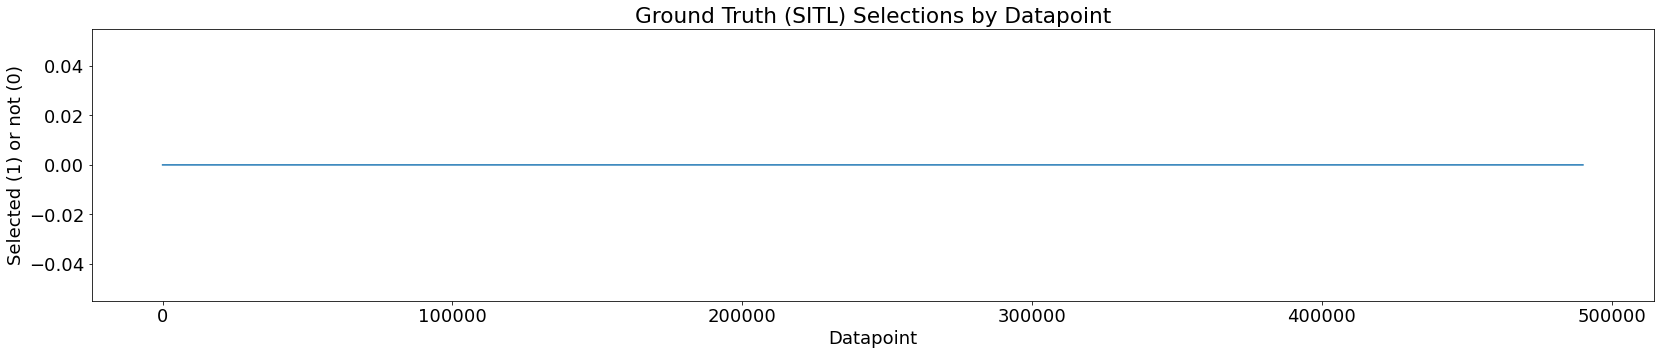

In [20]:
plt.figure(figsize=(28, 5))
plt.plot(validation_y.astype(int))
plt.title("Ground Truth (SITL) Selections by Datapoint")
plt.ylabel('Selected (1) or not (0)')
plt.xlabel('Datapoint')
plt.show()

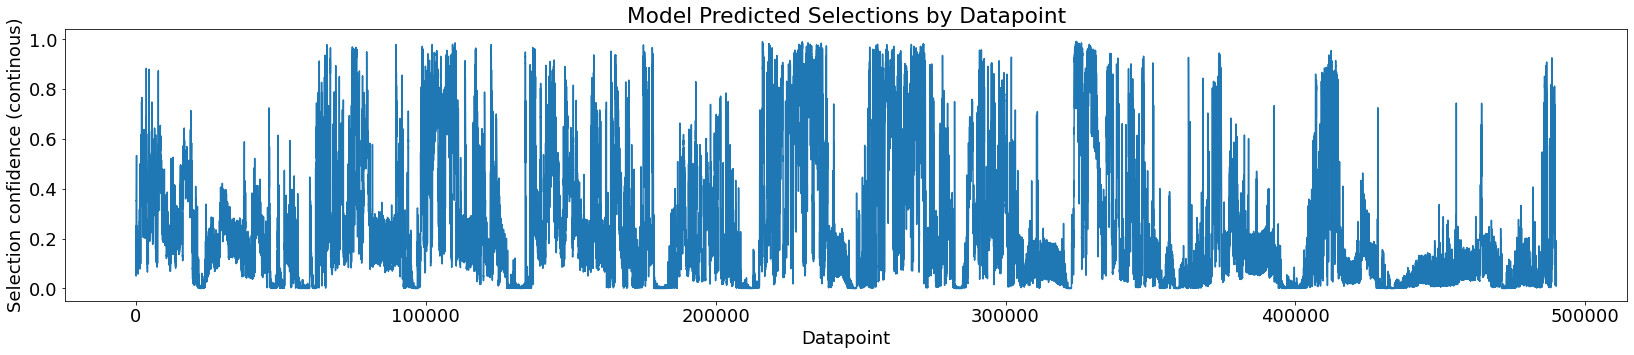

In [28]:
plt.figure(figsize=(28, 5))
plt.plot(test_predictions.flatten())
plt.title("Model Predicted Selections by Datapoint")
plt.ylabel('Selection confidence (continous)')
plt.xlabel('Datapoint')
plt.show()


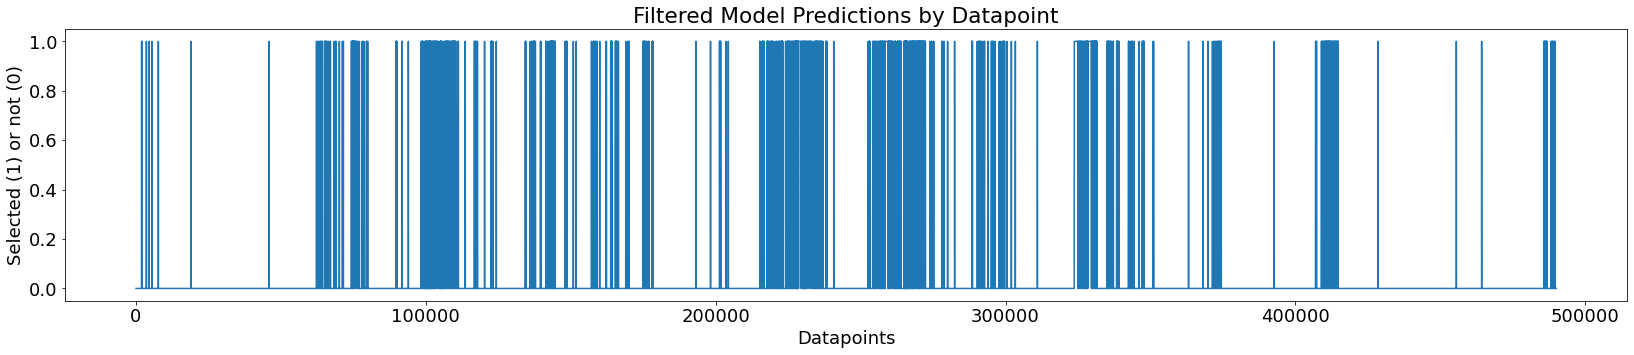

In [30]:
t_output = [0 if x < 0.7 else 1 for x in test_predictions.flatten()]
plt.figure(figsize=(28, 5))
plt.plot(t_output)
plt.title("Filtered Model Predictions by Datapoint")
plt.ylabel('Selected (1) or not (0)')
plt.xlabel('Datapoints')
plt.show()

In [ ]:
y_eval = y_eval.astype(int)
y_eval = y_eval.flatten()

y_true = test_predictions.squeeze()
y_true = y_true.flatten()
print(y_eval.shape, y_true.shape)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_eval, y_true)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve - AUC = {:.2f}'.format(auc(fpr, tpr)))
plt.legend(loc="lower right")

plt.show()

In [ ]:
y_true = np.clip(y_true, 0, 1)
print(y_true)

In [ ]:
cm = confusion_matrix(y_eval, t_output)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()